In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.attribute import YEAR_ATTR, AGE_ATTR, POPULATION_ATTR, SEX_ATTR
from data.error import finite_classical_error_margin, kish_effective_sample_size
from data.location import CANTON_ATTR
from data.selects.columns import TOTAL_WEIGHT, RESPONDENT_ID
from utils.distribution import merge_proportional, column_total_variance_distance

In [2]:
from data.selects.source import get_fors_selects
from data.population import get_bfs_population_cga
from data.location import load_cantons_metadata

cantons_metadata = load_cantons_metadata()
canton_names = cantons_metadata.set_index(CANTON_ATTR).cantonAbbreviation
selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [3]:
from data.population import get_electorate

year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year].dropna(axis=1, how='all')
electorate_year_df = get_electorate(population_df[population_df[YEAR_ATTR] == year])

print(f'Year: {year}')
print(f'Number of selects respondents: {len(selects_year_df)}')
print(f'Electorate: {electorate_year_df[POPULATION_ATTR].sum()}')

Year: 2019
Number of selects respondents: 6664
Electorate: 5291269


Sample size (before spread): 6664
Sample size (after spread): 160350
Effective sample size (before spread): 2645.3
Effective sample size (after spread): 27620.3


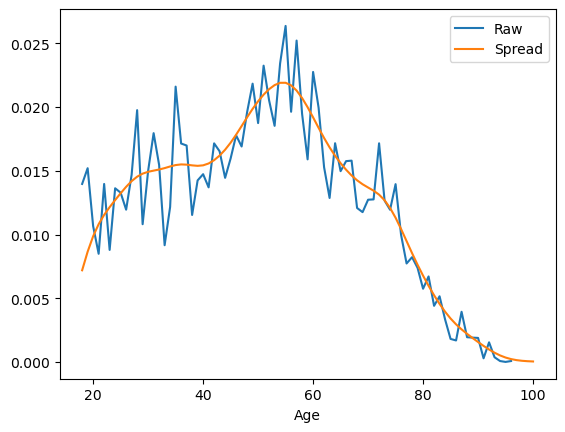

In [4]:
import data.selects.process as selects_module

importlib.reload(selects_module)

age_spread_selects_year_df = selects_module.spread_age(selects_year_df)

merge_proportional(
    selects_year_df.groupby(AGE_ATTR)[TOTAL_WEIGHT].sum().rename('Raw'),
    age_spread_selects_year_df.groupby(AGE_ATTR)[TOTAL_WEIGHT].sum().rename('Spread')
).sort_index().plot()

print('Sample size (before spread):', len(selects_year_df))
print('Sample size (after spread):', len(age_spread_selects_year_df))
print(f'Effective sample size (before spread): {
kish_effective_sample_size(selects_year_df[TOTAL_WEIGHT])
:.1f}')
print(f'Effective sample size (after spread): {
kish_effective_sample_size(age_spread_selects_year_df[TOTAL_WEIGHT])
:.1f}')

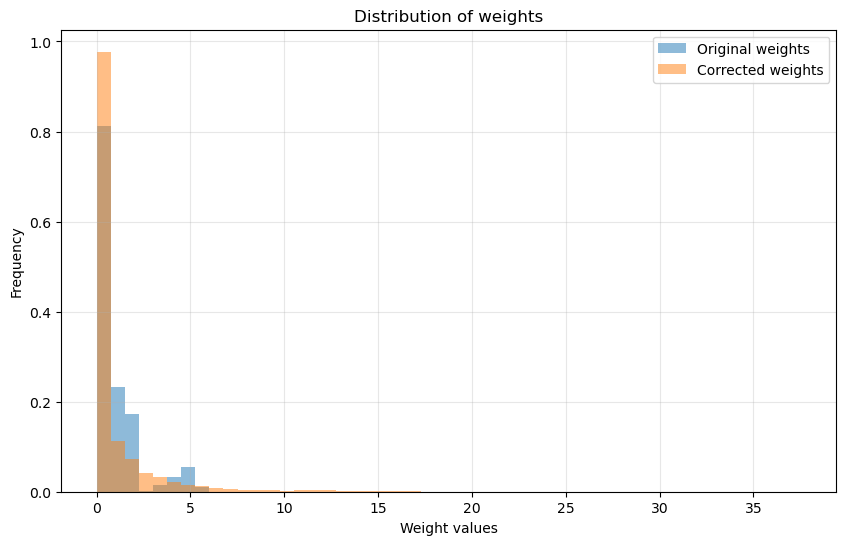

In [5]:
import data.selects.process as selects_module

importlib.reload(selects_module)

corrected_selects_year_df = selects_module.post_process_selects(selects_year_df, electorate_year_df)

# Plot histogram comparing original and corrected weights
fig, ax = plt.subplots(figsize=(10, 6))
bin_edges = np.linspace(
    min(selects_year_df[TOTAL_WEIGHT].min(), corrected_selects_year_df[TOTAL_WEIGHT].min()),
    max(selects_year_df[TOTAL_WEIGHT].max(), corrected_selects_year_df[TOTAL_WEIGHT].max()),
    51
)
selects_year_df[TOTAL_WEIGHT].plot.hist(
    bins=bin_edges, alpha=0.5, label='Original weights', ax=ax, density=True
)
corrected_selects_year_df[TOTAL_WEIGHT].plot.hist(
    bins=bin_edges, alpha=0.5, label='Corrected weights', ax=ax, density=True
)
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.title('Distribution of weights')
plt.legend()
plt.grid(alpha=0.3)

Demographics TVD:
Selects                0.381718
Selects (corrected)    0.120503
dtype: float64


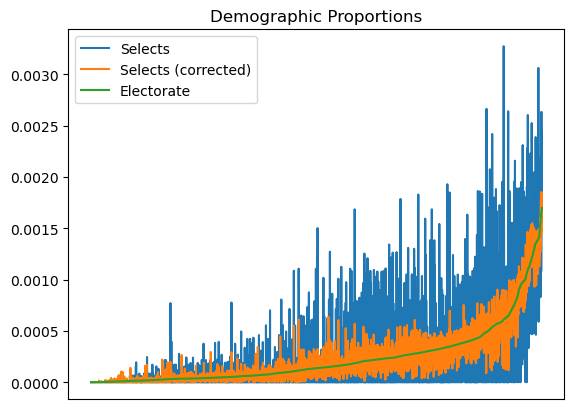

In [6]:
selects_demographics_grouping = selects_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, 'sg3'], observed=True, dropna=False
)
weighted_selects_demographics_grouping = corrected_selects_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, 'sg3'], observed=True, dropna=False
)

selects_demographics = selects_demographics_grouping[TOTAL_WEIGHT].sum().rename('Selects')
weighted_selects_demographics = weighted_selects_demographics_grouping[TOTAL_WEIGHT].sum().rename('Selects (corrected)')
electorate_demographics = electorate_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, CANTON_ATTR], observed=True, dropna=False
)[POPULATION_ATTR].sum().rename('Electorate')

demographic_proportions = merge_proportional(
    selects_demographics, weighted_selects_demographics,
    electorate_demographics,
).fillna(0).sort_values(['Electorate'])
demographic_proportions.index.rename(CANTON_ATTR, level=2, inplace=True)
demographic_proportions.rename(index=canton_names, level=CANTON_ATTR, inplace=True)

ax = demographic_proportions.plot(title='Demographic Proportions')
ax.get_xaxis().set_visible(False)
print('Demographics TVD:')
print(column_total_variance_distance(demographic_proportions, 'Electorate'))

Total missing: 193 demographics (0.11% of electorate)
Over age of 80: 193 demographics (0.11% of electorate)


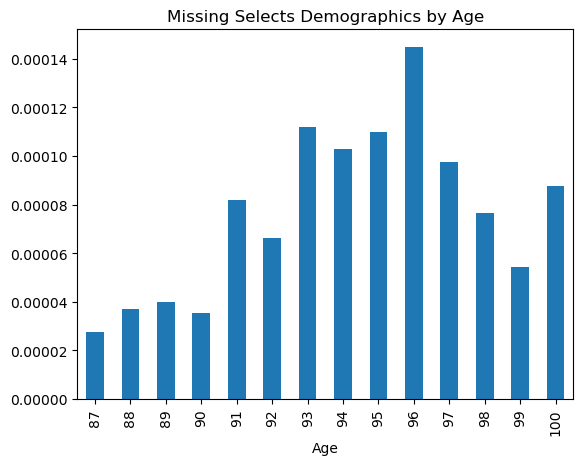

Rest: 0 demographics (0.00% of electorate)


,,,Selects,Selects (corrected),Electorate
Age,Sex,Canton,,,


In [7]:
missing_selects_demographics = demographic_proportions[demographic_proportions['Selects (corrected)'] == 0]


def _show_missing_proportion(description: str, missing: pd.DataFrame) -> None:
    electorate_proportion = (missing['Electorate'].sum() / demographic_proportions['Electorate'].sum())
    print(f'{description}: {missing['Electorate'].count()} demographics '
          f'({100 * electorate_proportion:.2f}% of electorate)')


_show_missing_proportion('Total missing', missing_selects_demographics)

# Show overage demographics
OVERAGE_THRESHOLD = 80
is_overage = missing_selects_demographics.index.get_level_values(AGE_ATTR) > OVERAGE_THRESHOLD
_show_missing_proportion(f'Over age of {OVERAGE_THRESHOLD}', missing_selects_demographics[is_overage])
missing_selects_demographics.groupby(level=AGE_ATTR)['Electorate'].sum().plot(
    kind='bar', title='Missing Selects Demographics by Age'
)
plt.show()

# Rest of the missing demographics
missing_selects_demographics = missing_selects_demographics[~is_overage]
_show_missing_proportion('Rest', missing_selects_demographics)
missing_selects_demographics

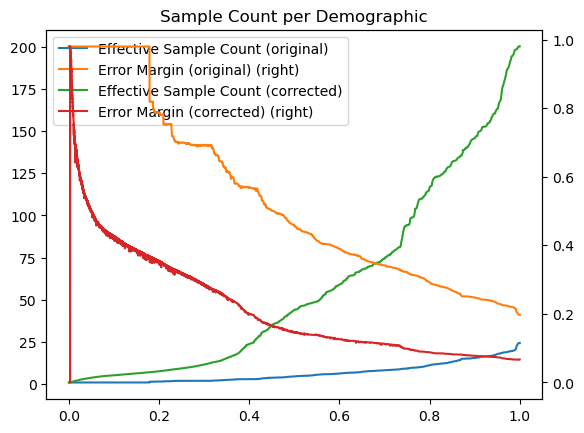

Original sample size: 6664
Age spread sample size: 160350
Total error margin (original): 1.905pp
Total error margin (corrected): 1.920pp


In [8]:
def _compute_demographic_stats(selects_grouping, version: str):
    sample_count = selects_grouping.apply(
        lambda group: kish_effective_sample_size(group[TOTAL_WEIGHT], group[RESPONDENT_ID]),
        include_groups=False
    ).sort_values().rename(f'Effective Sample Count ({version})')
    population_size = electorate_demographics[sample_count.index]
    error_margin = pd.concat([sample_count, population_size], axis=1) \
        .apply(lambda x: np.nan if x.iloc[1] == 0 else finite_classical_error_margin(x.iloc[0], x.iloc[1]), axis=1) \
        .rename(f'Error Margin ({version})')
    return sample_count, population_size, error_margin


demographic_sample_count, demographic_population_size, demographic_error_margin = \
    _compute_demographic_stats(selects_demographics_grouping, 'original')
corrected_demographic_sample_count, corrected_demographic_population_size, corrected_demographic_error_margin = \
    _compute_demographic_stats(weighted_selects_demographics_grouping, 'corrected')

pd.concat([
    pd.concat([demographic_sample_count, demographic_error_margin], axis=1) \
        .set_index(demographic_sample_count.cumsum() / demographic_sample_count.sum()),
    pd.concat([corrected_demographic_sample_count, corrected_demographic_error_margin], axis=1) \
        .set_index(corrected_demographic_sample_count.cumsum() / corrected_demographic_sample_count.sum())
], axis=1).sort_index().interpolate().bfill().ffill().plot(
    title="Sample Count per Demographic",
    secondary_y=('Error Margin (original)', 'Error Margin (corrected)')
)
plt.show()

print(f'Original sample size: {len(selects_year_df)}')
print(f'Age spread sample size: {len(corrected_selects_year_df)}')

# Cannot simply calculate the total error margin from the individual buckets because they are not independent.
print(f'Total error margin (original): {100 * finite_classical_error_margin(
    kish_effective_sample_size(selects_year_df[TOTAL_WEIGHT], selects_year_df[RESPONDENT_ID]),
    electorate_demographics.sum()
):.3f}pp')
print(f'Total error margin (corrected): {100 * finite_classical_error_margin(
    kish_effective_sample_size(corrected_selects_year_df[TOTAL_WEIGHT], corrected_selects_year_df[RESPONDENT_ID]),
    electorate_demographics.sum()
):.3f}pp')